## IRIS and MNIST classification using TTN and MERA

In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import os, csv

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
from sklearn.model_selection import train_test_split
# TODO: mottonen will be changed to its subpackage and the relative path will change
from mottonen import encode_classical_datapoint

seed = 42
np.random.seed(seed)

In [2]:
!export IRIS_URL="https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data" && curl $IRIS_URL > iris.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4551  100  4551    0     0  18728      0 --:--:-- --:--:-- --:--:-- 18728


## Data Encoding

### IRIS data set encoding
We standardize the data and make this a binary classification problem.

1. First we will fetch the IRIS dataset
2. Only select the datagrams with labels 1 or 2, with label 1 as 0 and 2 as 1
3. Standadize the data so that each dimension is only $[0, \frac{\pi}{2}]$
4. Use Mottonen[] to generate the quantum data encoding circuits using qubit encoding

### Standardize the data

In [3]:
with open('./iris.csv') as csv_file:
    reader = csv.reader(csv_file, delimiter=',')
    rows = list(reader)
    rows.pop()
    data = [row for row in rows if row[4] != 'Iris-virginica']
    for datum in data:
        if datum[4] == 'Iris-setosa':
            datum[4] = 0
        else:
            datum[4] = 1
    data = np.array(data, dtype=np.float32)
    labels = data[:,4]
    data = data[:,:4]
    data = data.reshape(100, 4, 1)
    data = (data-np.min(data))/(np.max(data)-np.min(data))
    data = np.concatenate((np.cos(np.pi*0.5*data), np.sin(np.pi*0.5*data)), axis=2)
    print(data.shape)

(100, 4, 2)


### Encode the data as quantum circuits and create tensors

In [4]:
def get_encoded_data_batch(data, labels):
    _data = []
    # only reason for using GridQubit is because the serializer in
    # cirq for converting it into a tensor only works for GridQubits
    # in 'this' cirq release.
    qubits = cirq.GridQubit.rect(1,4)
    for idx in range(data.shape[0]):
        datapoint = data[idx]
        _circuit = cirq.Circuit()
        for i in range(4):
            _circuit.append(encode_classical_datapoint(np.array(datapoint[i][::-1]), [qubits[i]]))
        _data.append(_circuit)
    X_train, X_test, y_train, y_test = train_test_split(_data, labels, test_size=0.25, random_state=seed)
    X_train, X_test = tfq.convert_to_tensor(X_train), tfq.convert_to_tensor(X_test)
    
    return X_train, X_test, y_train, y_test

In [5]:
X_train, X_test, y_train, y_test = get_encoded_data_batch(data, labels)

## TTN Model

### Model Definitions

In [6]:
def ttn_real_unitary(qubits, symbols):
    circuit = cirq.Circuit()
    circuit.append(cirq.ry(symbols[0])(qubits[0]))
    circuit.append(cirq.ry(symbols[1])(qubits[1]))
    circuit.append(cirq.CNOT(qubits[0], qubits[1]))
    return circuit

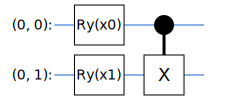

In [7]:
SVGCircuit(ttn_real_unitary(cirq.GridQubit.rect(1, 2), sympy.symbols('x0:2')))

In [8]:
def ttn_model_iris(qubits):
    symbols, circuit = sympy.symbols('x0:6'), cirq.Circuit()
    circuit.append(ttn_real_unitary(qubits[:2], symbols[:2]))
    circuit.append(ttn_real_unitary(qubits[2:4], symbols[2:4]))
    circuit.append(ttn_real_unitary(qubits[1:3], symbols[4:6]))
    return circuit

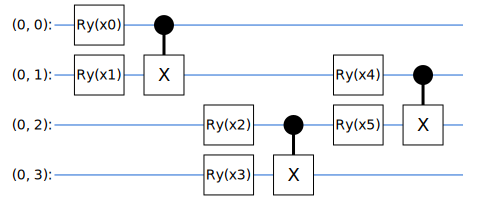

In [9]:
SVGCircuit(ttn_model_iris(cirq.GridQubit.rect(1,4)))

In [10]:
@tf.function
def custom_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true)
    y_pred = tf.map_fn(lambda x: 1.0 if x >= 0.0 else 0.0, y_pred)
    return tf.keras.backend.mean(tf.keras.backend.equal(y_true, y_pred))

In [11]:
# declare qubits and readout operators
cluster_state_bits = cirq.GridQubit.rect(1, 4)
readout_operators = cirq.Z(cluster_state_bits[3])

iris_ttn_model = ttn_model_iris(cluster_state_bits)
iris_data_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
iris_pqc = tfq.layers.PQC(iris_ttn_model, readout_operators)
iris_measurement_output = iris_pqc(iris_data_input)

iris_model = tf.keras.Model(inputs=iris_data_input, outputs=iris_measurement_output)

# Standard compilation for classification
iris_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), 
                   loss=tf.keras.losses.MSE, metrics=[custom_accuracy])
tf.keras.utils.plot_model(iris_model, show_shapes=True, dpi=70)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


### Training

In [ ]:
history = iris_model.fit(x=X_train, y=y_train, batch_size=16, epochs=25, verbose=1, validation_data=(X_test, y_test))

Train on 75 samples, validate on 25 samples
Epoch 1/25
16/75 [=====>........................] - ETA: 4s - loss: 0.9350 - custom_accuracy: 0.5625

In [ ]:
plt.plot(history.history['loss'])
plt.title("Learning to classify quantum data")
plt.xlabel("Iterations")
plt.ylabel("Error in classification")
plt.show()
print("Final loss value:")
print(history.history["loss"][-1])